## Setup


In [1]:
!pip3 -q install torch torchvision torchaudio tensorboard matplotlib tqdm

In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import numpy as np


def seed_everything(SEED):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True

def get_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'mps' if torch.backends.mps.is_available() else device
    return device


SEED = 42
seed_everything(SEED)
device = get_device()

## 1. Get the data


In [3]:
# Define a transform to convert the data to PyTorch tensors and normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    ])

# Create datasets for training & validation, download if necessary
training_data = torchvision.datasets.FashionMNIST('data', train=True, transform=transform, download=True)
testing_data = torchvision.datasets.FashionMNIST('data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
BATCH_SIZE = 128
training_dataloader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)

# Report split sizes
print('Training set has {} instances'.format(len(training_data)))
print('Validation set has {} instances'.format(len(testing_data)))
print(f' Classes: {training_data.classes}')
print(f'Batch size: {BATCH_SIZE}')
print('Training batches: {}'.format(len(training_dataloader)))
print('Testing batches: {}'.format(len(testing_dataloader)))

Training set has 60000 instances
Validation set has 10000 instances
 Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Batch size: 128
Training batches: 469
Testing batches: 79


## 2. Explore the data


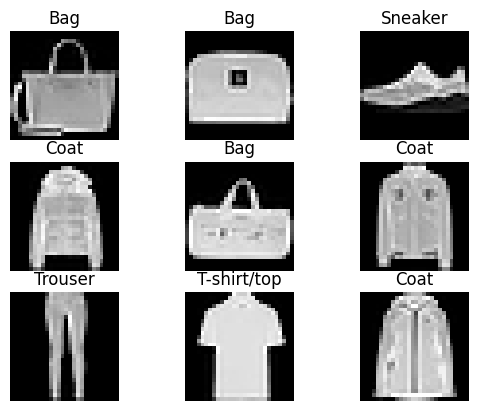

In [4]:
import matplotlib.pyplot as plt

classes = training_data.classes

def visualize_data(data):
    n_samples = 9
    sample_indices = np.random.choice(len(data), n_samples, replace=False)
    sample_images =data.data[sample_indices]
    sample_labels = data.targets[sample_indices]
    sample_labels=  [training_data.classes[label] for label in sample_labels]

    for i in range(n_samples):
        plt.subplot(3, 3, i+1)
        img = sample_images[i].cpu()
        label  = sample_labels[i]
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')

visualize_data(training_data)

## 3. Build Generator


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim_size = 128

        self.latent_space = nn.Sequential(
            nn.Linear(self.latent_dim_size, self.latent_dim_size*8*8),
            nn.Flatten(),
            nn.LeakyReLU(0.2)
        )
        self.upsample_1 = nn.Sequential(
            nn.Upsample(size=(16, 16), mode='bilinear'),
            nn.Conv2d(self.latent_dim_size, 128, kernel_size=5 ,padding='same'),
            nn.LeakyReLU(0.2),
        )
        self.upsample_2 = nn.Sequential(
            nn.Upsample(size=(28, 28), mode='bilinear'),
            nn.Conv2d(128, 128, kernel_size=5 ,padding='same'),
            nn.LeakyReLU(0.2),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4 ,padding='same'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=4 ,padding='same'),
            nn.LeakyReLU(0.2),
        )

        self.output = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=3 ,padding='same'),
        )

    def forward(self, x):
        x = self.latent_space(x)
        x = x.reshape(-1, self.latent_dim_size, 8, 8)
        x = self.upsample_1(x)
        x = self.upsample_2(x)
        x = self.conv(x)
        y = self.output(x)
        return y

Let's convince ourselves that our generator has the correct input and output shapes.


In [6]:
# Sanity check
generator = Generator()
X = torch.randn(1, 128)
print(f"Input shape: {X.shape}")
out = generator(X)
print(f"Output shape: {out.shape}")

X = torch.randn(32, 128)
print(f"Batch Input shape: {X.shape}")
out = generator(X)
print(f"Batch Output shape: {out.shape}")


Input shape: torch.Size([1, 128])
Output shape: torch.Size([1, 1, 28, 28])
Batch Input shape: torch.Size([32, 128])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


Batch Output shape: torch.Size([32, 1, 28, 28])


Let's also generate some sample images from the generator. These should be completely random without any structure right now.


In [7]:
# Generate some images
def generate_samples(generator, device):
    n_samples = 9
    generator.eval()
    generator.to(device)
    with torch.inference_mode():
        X = torch.randn(n_samples, 128).to(device)
        generated = generator(X)
        generated = generated.cpu().detach()

    # Visualize generated images
    plt.figure(figsize=(7, 7))
    plt.title('Generated Images')
    plt.axis('off')
    for i in range(n_samples):
        plt.subplot(3, 3, i+1)
        img = generated[i].squeeze()
        plt.imshow(img, cmap='gray')
        plt.axis('off')



<ipython-input-7-76212cd9876a>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i+1)


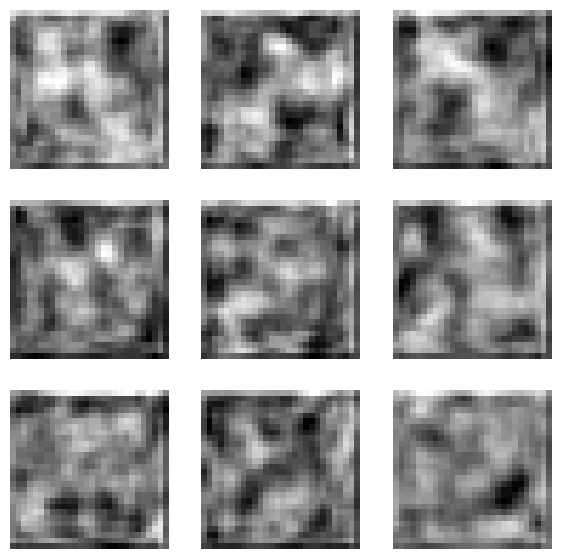

In [8]:
generate_samples(generator, device)

## 4. Build Discriminator

The discriminator will take the sample from the generator and the real data and try to classify them as real or fake. It will use a bunch of convolutional layers to find filters that can be used to classify the data. The output of the discriminator will be a single number logit.


In [9]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2),
        )
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*10*10, 1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        y = self.conv4(x)
        y = self.output(y)
        return y

Let's convince ourselves that the input and output shapes of the discriminator are correct.


In [10]:
# Sanity check
discriminator = Discriminator()
X = torch.randn(1, 1, 28, 28)
print(f"Input shape: {X.shape}")
out = discriminator(X)
print(f"Output shape: {out.shape}")

X = torch.randn(32, 1, 28, 28)
print(f"Batch Input shape: {X.shape}")
out = discriminator(X)
print(f"Batch Output shape: {out.shape}")

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 1])
Batch Input shape: torch.Size([32, 1, 28, 28])
Batch Output shape: torch.Size([32, 1])


## 5. Train

This is the main part of the code. We will train the GAN here. We need to train the discriminator and the generator in an alternating fashion. I will use the following algorithm:

1. Take a batch of real samples and a batch of fake samples from the generator.
2. Train the discriminator for one step on this batch. We will use the cross entropy loss. We want the discriminator to output 1 for real images and 0 for fake images. So we will compare the output of the discriminator with a tensor of zeros for the real images and a tensor of ones for the fake images.
3. Backpropagate the error through the discriminator.
4. Take a batch of fake samples from the generator and pass it through the discriminator to get the output. We don't need to calculate the gradients for the discriminator here, so set the model to eval mode.
5. Calculate the loss for the generator using the output from the discriminator. We want the generator to output images that the discriminator classifies as real. So compare the output of the discriminator with a tensor of ones for these fake images.
6. Backpropagate the error through the generator.
7. Repeat steps 1-6 for a number of epochs.


In [11]:
from tqdm import tqdm

def train(generator, discriminator, generator_loss_fn, discriminator_loss_fn, generator_optimizer, discriminator_optimizer, training_dataloader, device, epochs):
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1} of {epochs}")
        print("-"*20)

        epoch_g_loss, epoch_d_loss = 0., 0.

        for batch, (X_train, _) in enumerate(training_dataloader):
            # Move images to device
            X = X_train.to(device)

            # Real images and fake images
            generator.eval()
            d_real_X = X
            d_fake_X = generator(torch.randn(BATCH_SIZE, 128).to(device))

            # Train discriminator
            discriminator.train()

            # Get discriminator outputs for real and fake images
            d_real_Y = discriminator(d_real_X)
            d_fake_Y = discriminator(d_fake_X)
            d_Y = torch.cat([d_real_Y, d_fake_Y], dim=0)

            # Create labels for discriminator outputs based on real or fake
            d_Y_train = torch.cat([torch.zeros_like(d_real_Y), torch.ones_like(d_fake_Y)], dim=0)
            noise = torch.randn(d_Y.shape).to(device)
            d_Y_train += 0.20 * noise
            d_Y_train = d_Y_train

            # Calculate discriminator loss and update weights
            d_loss = discriminator_loss_fn(d_Y, d_Y_train)
            epoch_d_loss += d_loss
            discriminator_optimizer.zero_grad()
            d_loss.backward()
            discriminator_optimizer.step()

            # Train generator
            generator.train()

            # Generate fake images
            d_fake_X = generator(torch.randn(BATCH_SIZE, 128).to(device))

            # Get discriminator outputs for fake images
            discriminator.eval()
            # Get discriminator outputs for fake images
            d_fake_Y = discriminator(d_fake_X)

            # For generator, we want the discriminator to think the images are real (0)
            # So the output is compared to 0s (1 would mean fake)
            d_Y_train = torch.zeros_like(d_fake_Y).to(device)

            # Calculate generator loss and update weights
            g_loss = generator_loss_fn(d_fake_Y, d_Y_train)
            epoch_g_loss += g_loss
            generator_optimizer.zero_grad()
            g_loss.backward()
            generator_optimizer.step()

            if batch % 100 == 0:
                print(f"Batch {batch} | Generator Loss: {g_loss:.2f} | Discriminator Loss: {d_loss:.2f}")

        epoch_g_loss = epoch_g_loss / len(training_dataloader)
        epoch_d_loss = epoch_d_loss / len(training_dataloader)
        print(f"Generator Loss: {epoch_g_loss:.2f} - Discriminator Loss: {epoch_d_loss:.2f}")
        print("-"*20)

In [12]:
device = get_device()
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_loss_fn = nn.BCEWithLogitsLoss()
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_loss_fn = nn.BCEWithLogitsLoss()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

epochs = 10
train(generator, discriminator, generator_loss_fn, discriminator_loss_fn, generator_optimizer, discriminator_optimizer, training_dataloader, device, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 of 10
--------------------
Batch 0 | Generator Loss: 0.69 | Discriminator Loss: 0.69
Batch 100 | Generator Loss: 0.63 | Discriminator Loss: 0.61
Batch 200 | Generator Loss: 0.92 | Discriminator Loss: 0.49
Batch 300 | Generator Loss: 2.37 | Discriminator Loss: 0.07
Batch 400 | Generator Loss: 1.82 | Discriminator Loss: 0.24


 10%|█         | 1/10 [02:52<25:54, 172.73s/it]

Generator Loss: 1.33 - Discriminator Loss: 0.52
--------------------
Epoch 2 of 10
--------------------
Batch 0 | Generator Loss: 6.48 | Discriminator Loss: 0.44
Batch 100 | Generator Loss: 1.89 | Discriminator Loss: 0.16
Batch 200 | Generator Loss: 4.13 | Discriminator Loss: 0.09
Batch 300 | Generator Loss: 1.23 | Discriminator Loss: 0.29
Batch 400 | Generator Loss: 2.83 | Discriminator Loss: 0.77


 20%|██        | 2/10 [05:45<22:59, 172.48s/it]

Generator Loss: 2.56 - Discriminator Loss: 0.23
--------------------
Epoch 3 of 10
--------------------
Batch 0 | Generator Loss: 1.18 | Discriminator Loss: 0.19
Batch 100 | Generator Loss: 3.97 | Discriminator Loss: 0.04
Batch 200 | Generator Loss: 3.04 | Discriminator Loss: -0.03
Batch 300 | Generator Loss: 1.51 | Discriminator Loss: 0.11
Batch 400 | Generator Loss: 4.45 | Discriminator Loss: 0.22


 30%|███       | 3/10 [08:37<20:06, 172.37s/it]

Generator Loss: 2.26 - Discriminator Loss: 0.18
--------------------
Epoch 4 of 10
--------------------
Batch 0 | Generator Loss: 4.40 | Discriminator Loss: 1.15
Batch 100 | Generator Loss: 1.44 | Discriminator Loss: 0.24
Batch 200 | Generator Loss: 1.61 | Discriminator Loss: 0.40
Batch 300 | Generator Loss: 3.15 | Discriminator Loss: 0.11
Batch 400 | Generator Loss: 1.81 | Discriminator Loss: 0.16


 40%|████      | 4/10 [11:29<17:14, 172.34s/it]

Generator Loss: 1.52 - Discriminator Loss: 0.20
--------------------
Epoch 5 of 10
--------------------
Batch 0 | Generator Loss: 0.82 | Discriminator Loss: 0.18
Batch 100 | Generator Loss: 0.95 | Discriminator Loss: 0.04
Batch 200 | Generator Loss: 0.55 | Discriminator Loss: 0.18
Batch 300 | Generator Loss: 1.00 | Discriminator Loss: 0.07
Batch 400 | Generator Loss: 0.29 | Discriminator Loss: 0.41


 50%|█████     | 5/10 [14:21<14:21, 172.35s/it]

Generator Loss: 1.27 - Discriminator Loss: 0.21
--------------------
Epoch 6 of 10
--------------------
Batch 0 | Generator Loss: 1.38 | Discriminator Loss: 0.26
Batch 100 | Generator Loss: 0.84 | Discriminator Loss: 0.32
Batch 200 | Generator Loss: 1.31 | Discriminator Loss: -0.01
Batch 300 | Generator Loss: 1.09 | Discriminator Loss: 0.41
Batch 400 | Generator Loss: 0.03 | Discriminator Loss: 0.16


 60%|██████    | 6/10 [17:14<11:29, 172.37s/it]

Generator Loss: 353.49 - Discriminator Loss: 1.24
--------------------
Epoch 7 of 10
--------------------
Batch 0 | Generator Loss: 0.03 | Discriminator Loss: 0.10
Batch 100 | Generator Loss: 0.03 | Discriminator Loss: 0.06
Batch 200 | Generator Loss: 0.01 | Discriminator Loss: 0.13
Batch 300 | Generator Loss: 0.00 | Discriminator Loss: -0.03
Batch 400 | Generator Loss: 0.00 | Discriminator Loss: 0.18


 70%|███████   | 7/10 [20:06<08:37, 172.36s/it]

Generator Loss: 0.01 - Discriminator Loss: 0.01
--------------------
Epoch 8 of 10
--------------------
Batch 0 | Generator Loss: 0.01 | Discriminator Loss: 0.07
Batch 100 | Generator Loss: 0.00 | Discriminator Loss: 0.11
Batch 200 | Generator Loss: 0.00 | Discriminator Loss: -0.03
Batch 300 | Generator Loss: 0.02 | Discriminator Loss: -0.26
Batch 400 | Generator Loss: 0.00 | Discriminator Loss: -0.12


 80%|████████  | 8/10 [22:59<05:44, 172.35s/it]

Generator Loss: 0.01 - Discriminator Loss: 0.00
--------------------
Epoch 9 of 10
--------------------
Batch 0 | Generator Loss: 0.05 | Discriminator Loss: -0.36
Batch 100 | Generator Loss: 0.09 | Discriminator Loss: 0.01
Batch 200 | Generator Loss: 0.01 | Discriminator Loss: 0.09
Batch 300 | Generator Loss: 0.02 | Discriminator Loss: -0.08
Batch 400 | Generator Loss: 0.00 | Discriminator Loss: -0.09


 90%|█████████ | 9/10 [25:51<02:52, 172.32s/it]

Generator Loss: 0.08 - Discriminator Loss: 0.01
--------------------
Epoch 10 of 10
--------------------
Batch 0 | Generator Loss: 0.02 | Discriminator Loss: -0.24
Batch 100 | Generator Loss: 0.21 | Discriminator Loss: -0.19
Batch 200 | Generator Loss: 0.11 | Discriminator Loss: 0.33
Batch 300 | Generator Loss: 0.07 | Discriminator Loss: 0.23
Batch 400 | Generator Loss: 0.11 | Discriminator Loss: -0.20


100%|██████████| 10/10 [28:43<00:00, 172.37s/it]

Generator Loss: 0.08 - Discriminator Loss: 0.02
--------------------


## 6. Evaluate the results

Visualize the results of the trained generator. They should look like fashion items.


<ipython-input-7-76212cd9876a>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i+1)


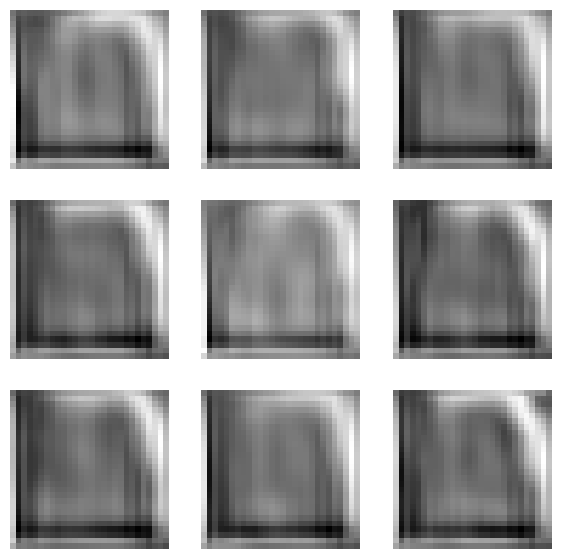

In [13]:
generate_samples(generator, device)

Clearly, the results are not perfect. We can improve the results by training for more epochs, using a larger network, or tuning the hyperparameters. But this is a good start. The images are now starting to look like fashion items.


## 7. Save the model


In [14]:
from pathlib import Path

def save_model(model, model_name):
    model_dir = Path("models")
    model_dir.mkdir(exist_ok=True)
    torch.save(model.state_dict(), model_dir / model_name)

save_model(generator, "generator.pth")
save_model(discriminator, "discriminator.pth")